In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Check if GPU is available; if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda
Using device: cuda


In [13]:
# Function to generate sine wave data with added random phase shifts for diversity
def generate_sine_data(num_samples=1000, num_points=50):
    x = np.linspace(0, 2 * np.pi, num_points)  # Fixed x-axis values
    data = [np.sin(x + np.random.uniform(0, 2 * np.pi)) for _ in range(num_samples)]  # Randomized sine waves
    return torch.tensor(data, dtype=torch.float32)


In [14]:
# Define the Generator neural network class
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),  # LeakyReLU to prevent dying neurons
            nn.BatchNorm1d(128),  # BatchNorm to stabilize training
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Tanh to constrain output between -1 and 1 (suitable for sine waves)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
# Define the Discriminator neural network class
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),  # LeakyReLU for better gradient flow
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Sigmoid to output probabilities
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# Hyperparameters for GAN training
num_points = 50  # Number of points in each sine wave
z_dim = 16  # Dimensionality of the random noise input to the generator
num_epochs = 5000  # Total number of epochs for training
batch_size = 64  # Batch size for training
learning_rate = 0.0002  # Learning rate for optimizers
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer (momentum term)

In [17]:
# Generate training data and create DataLoader
sine_data = generate_sine_data(num_samples=1000, num_points=num_points)
dataset = torch.utils.data.TensorDataset(sine_data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

<ipython-input-3-2ab866a2d70c>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(data, dtype=torch.float32)


In [18]:
# Initialize generator and discriminator, move them to the selected device
generator = Generator(input_dim=z_dim, output_dim=num_points).to(device)
discriminator = Discriminator(input_dim=num_points).to(device)

In [19]:
# Loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [21]:
# Lists to store losses for visualization
g_losses, d_losses = [], []

# Training loop for GAN
for epoch in range(num_epochs):
    for i, (real_data,) in enumerate(data_loader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # Create labels for real and fake data
        real_labels = torch.ones(batch_size, 1, device=device)  # Label 1 for real data
        fake_labels = torch.zeros(batch_size, 1, device=device)  # Label 0 for fake data

        # Train Discriminator
        d_optimizer.zero_grad()

        # Loss for real data
        d_real_output = discriminator(real_data)
        d_real_loss = criterion(d_real_output, real_labels)

        # Loss for fake data
        z = torch.randn(batch_size, z_dim, device=device)  # Generate random noise
        fake_data = generator(z)  # Generate fake sine waves
        d_fake_output = discriminator(fake_data.detach())  # Detach to avoid training the generator here
        d_fake_loss = criterion(d_fake_output, fake_labels)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()  # Backpropagation
        d_optimizer.step()  # Update discriminator weights

        # Train Generator
        g_optimizer.zero_grad()

        g_output = discriminator(fake_data)  # Discriminator's output on fake data
        g_loss = criterion(g_output, real_labels)  # Generator tries to fool the discriminator

        g_loss.backward()  # Backpropagation
        g_optimizer.step()  # Update generator weights

        # Record losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # Log progress every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [500/5000], D Loss: 0.0801, G Loss: 5.1667
Epoch [1000/5000], D Loss: 0.0425, G Loss: 7.0513
Epoch [1500/5000], D Loss: 0.0371, G Loss: 11.5070
Epoch [2000/5000], D Loss: 0.0133, G Loss: 10.3340
Epoch [2500/5000], D Loss: 0.0653, G Loss: 8.9283
Epoch [3000/5000], D Loss: 0.1075, G Loss: 5.0489
Epoch [3500/5000], D Loss: 0.0453, G Loss: 9.7977
Epoch [4000/5000], D Loss: 0.0713, G Loss: 7.2571
Epoch [4500/5000], D Loss: 0.0366, G Loss: 8.2410
Epoch [5000/5000], D Loss: 0.0187, G Loss: 7.2356


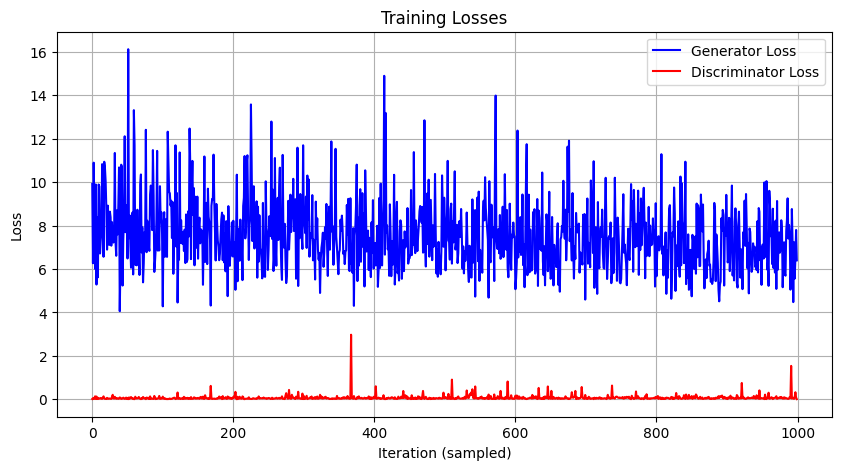

In [22]:
# Plot training losses for both generator and discriminator
plt.figure(figsize=(10, 5))
plt.plot(g_losses[::len(g_losses)//1000], label='Generator Loss', color='blue')
plt.plot(d_losses[::len(d_losses)//1000], label='Discriminator Loss', color='red')
plt.title('Training Losses')
plt.xlabel('Iteration (sampled)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()